### Problem Overview

This notebook implements the optimization model proposed in the paper *"Optimizing the Availability of Medical Applications"*, focusing on energy-efficient scheduling of **Modular Application Functions (MAFs)** on multiple **Processing Units (PUs)**. The goal is to maximize the availability of medical application services while minimizing energy consumption and resource overload.

The model accounts for:

- Task activation and assignment
- Selection of energy levels per task
- PU energy consumption and utilization
- End-to-end latency constraints for task chains
- Load balancing and potential task migration

---

### Objective Function

We aim to **maximize** the following multi-objective function:

$$
\max F = \alpha_1 \sum_{k=1}^{K} z_k - \alpha_2 \sum_{i=1}^{n} E_{i,K_i} - \alpha_3 \sum_{j=1}^{m} E_{\text{PU},j}
$$

Where:

- \( z_k \): Binary variable indicating whether task chain \( k \) is accepted  
- \( E_{i,K_i} \): Energy consumption of task \( i \) at energy level \( K_i \)  
- \( E_{\text{PU},j} \): Total energy consumed by PU \( j \)  
- \( \alpha_1, \alpha_2, \alpha_3 \): Trade-off weights for chain activation, task energy, and PU energy

---

### Constraints

1. **End-to-End Latency for Task Chains**:
$$
\sum_{i \in C_k} L_{i,K_i} + \sum_{(i,j) \in C_k} L_{\text{comm},(i,j)} \leq L_{\text{max},k}, \quad \forall k
$$

2. **Task Assignment Constraint**:
$$
\sum_{j=1}^{m} w_{i,j} = \delta_i, \quad \forall i
$$

3. **Single Energy Level Selection per Task**:
$$
\sum_{k=1}^{|K|} y_{i,k} = 1, \quad \forall i
$$

4. **PU Capacity Constraint**:
$$
\sum_{i=1}^{n} w_{i,j} \cdot L_{i,K_i} \leq C_{\text{PU},j}, \quad \forall j
$$

5. **PU Utilization Definition**:
$$
U_j = \frac{\sum_{i=1}^{n} w_{i,j} \cdot L_{i,K_i}}{T_{\text{total}}}, \quad \forall j
$$

6. **PU Energy Consumption Model**:
$$
E_{\text{PU},j} = P_{\text{idle},j} \cdot \left(T_{\text{total}} - \sum_{i=1}^{n} w_{i,j} \cdot L_{i,K_i} \right) + (P_{\text{max},j} - P_{\text{idle},j}) \cdot U_j \cdot T_{\text{total}}, \quad \forall j
$$

7. **PU Energy Upper Bound**:
$$
E_{\text{PU},j} \leq E_{\text{PU},\max}, \quad \forall j
$$

8. **Chain-to-Task Binding**:  
If a task chain \( z_k = 0 \), then all tasks \( i \in C_k \) must:
- Be deactivated: \( \delta_i = 0 \)
- Not be assigned to any PU: \( w_{i,j} = 0 \)
- Not select any energy level: \( y_{i,k} = 0 \)

---

###  Implemented Models

This notebook compares the following scheduling strategies:

- **Baseline**:  
  All activated tasks run at the **highest energy level** (i.e., fastest but most energy-consuming). No optimization is applied.

- **Optimal (Gurobi)**:  
  Uses **Mixed Integer Programming** with Gurobi to find the best combination of task activation, PU assignment, and energy level selection that maximizes the objective under all constraints.

- **Greedy**:  
  A custom-designed greedy heuristic that assigns tasks to PUs and selects energy levels with the goal of satisfying latency and energy constraints as efficiently as possible. It prioritizes chain acceptance but may not achieve the global optimum.

---


### Package Imports & Solver Setup

We start by importing the necessary Python libraries for optimization, data handling, and visualization.

The `configure_model()` function sets the parameters for the Gurobi solver:

- `OutputFlag = 0`: disables verbose console output
- `TimeLimit = 500`: limits solving time to 100 seconds
- `MIPGap = 0.05`: allows up to 5% optimality gap
- `MIPFocus = 1`: focuses on feasibility first
- `Heuristics = 0.8`: enables Gurobi's heuristics to speed up finding good solutions
- `Threads = 8`: allows parallel computation using 8 threads


In [3]:
import gurobipy as gp
from gurobipy import Model, GRB, quicksum
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
import time
from IPython.display import display, Markdown
import pandas as pd

def configure_model(model):
    """
    Configure the Gurobi solver parameters to control optimization behavior.
    """
    model.Params.OutputFlag = 0       # Suppress solver output
    model.Params.TimeLimit = 500      # Set maximum solving time (seconds)
    model.Params.MIPGap = 0.05        # Set acceptable optimality gap (5%)
    model.Params.Presolve = 2         # Use aggressive presolve
    model.Params.MIPFocus = 1         # Focus on finding feasible solutions quickly
    model.Params.Heuristics = 0.8     # Enable heuristics to guide search
    model.Params.Threads = 8          # Use 8 threads for parallel computation

### Parameter Configuration

We define all the core parameters needed for our optimization model:

- `m = 8`: Number of processing units (PUs)
- `K = 5`: Number of energy levels
- `L_levels`: Latency values for each energy level (lower latency → higher energy)
- `E_levels`: Energy consumption for each level
- `CPU_capacity`: CPU limits for each PU
- `f_v_levels`: CPU usage associated with energy levels
- `P_idle`, `P_max`: Power bounds for each PU
- `T_total = 300`: Simulation horizon in time units

#### Task Chain Configuration

We define 20 task chains with various lengths. Each task belongs to a single chain.  
Each chain is assigned a **maximum allowed end-to-end latency** calculated as:

$$
L_{\text{max}, k} = (1 + 0.2) \cdot \text{min}(L_{\text{levels}}) \cdot |C_k|
$$


In [4]:
# Number of Processing Units (PUs)
m = 8

# Number of energy levels
K = 5

# Latency levels per energy level
L_levels = [25, 20, 15, 12, 10]

# Energy consumption per task at each level
E_levels = [13, 28, 38, 45, 120]

# Max PU energy limits
E_PU_max = [8000] * m

# PU CPU capacities
CPU_capacity = [3000] * m

# CPU frequency/usage level per energy level
f_v_levels = [30, 40, 60, 80, 100]

# Idle and max power of each PU
P_idle = [16] * m
P_max = [40] * m

# Total simulation time (time slots)
T_total = 300

# Total number of tasks
total_tasks = 150

# Task chain definitions (dict: chain_id → list of task indices)
from collections import Counter

chain_tasks = {
    0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    1: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
    2: [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
    3: [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
    4: [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
    5: [50, 51, 52, 53, 54, 55, 56, 57],
    6: [58, 59, 60],
    7: [61, 62, 63],
    8: [64, 65, 66],
    9: [67, 68, 69],
    10: [70, 71, 72],
    11: [73, 74, 75],
    12: [76, 77, 78],
    13: [79, 80, 81],
    14: [82, 83, 84],
    15: [85, 86, 87],
    16: [88, 89, 90],
    17: [91, 92, 93],
    18: [94, 95, 96],
    19: [97, 98, 99]
}

num_chains = len(chain_tasks)

# Get total number of tasks from chain definitions
n = max(max(v) for v in chain_tasks.values()) + 1

# Maximum latency constraint per chain (with buffer factor)
buffer = 0.2  # 20% tolerance
L_max = [int(len(chain_tasks[k]) * min(L_levels) * (1 + buffer)) for k in chain_tasks]


### Gurobi Model Implementation

This function `run_gurobi_model()` builds and solves the main optimization problem using Gurobi.

Key Features:
- **Supports baseline mode** where all tasks use the highest energy level.
- Defines binary variables for:
  - `delta[i]`: whether task `i` is active
  - `w[i,j]`: assignment of task `i` to PU `j`
  - `y[i,k]`: energy level selection for task `i`
  - `z[k]`: whether chain `k` is accepted
- Computes PU utilization and energy consumption
- Maximizes chain acceptance while minimizing task and PU energy
- Returns a dictionary with detailed results, including:
  - Activated chains
  - PU-task assignments
  - Task energy level choices
  - Runtime and energy metrics


In [ ]:
#Gurobi Baseline and Optimal
def run_gurobi_model(alpha_1, alpha_2, alpha_3, baseline=False, E_PU_max=None):
    model = gp.Model("MAF_Optimization")
    configure_model(model)
    if E_PU_max is None:
        E_PU_max = [8000] * m  

    
    delta = model.addVars(n, vtype=GRB.BINARY, name="delta")
    w = model.addVars(n, m, vtype=GRB.BINARY, name="w")
    y = model.addVars(n, K, vtype=GRB.BINARY, name="y")
    z = model.addVars(num_chains, vtype=GRB.BINARY, name="z")
    E_PU = model.addVars(m, name="E_PU")

    if baseline:
        for i in range(n):
            model.addConstr(y[i, K - 1] == delta[i])
            for k in range(K - 1):
                model.addConstr(y[i, k] == 0)

    for i in range(n):
        model.addConstr(gp.quicksum(w[i, j] for j in range(m)) == delta[i])
        model.addConstr(gp.quicksum(y[i, k] for k in range(K)) == delta[i])
        for k in range(K):
            model.addConstr(y[i, k] <= delta[i])  # Ensure y[i,k]=0 if task is inactive

    for k in range(num_chains):
        model.addConstr(gp.quicksum(delta[i] for i in chain_tasks[k]) == z[k] * len(chain_tasks[k]))
        delay_chain = gp.quicksum(y[i, k_] * L_levels[k_] for i in chain_tasks[k] for k_ in range(K))
        model.addConstr(delay_chain <= L_max[k])

    for j in range(m):
        model.addConstr(
            gp.quicksum(w[i, j] * gp.quicksum(y[i, k] * f_v_levels[k] for k in range(K)) for i in range(n)) <= CPU_capacity[j]
        )
        active_time = gp.quicksum(w[i, j] * gp.quicksum(y[i, k] * L_levels[k] for k in range(K)) for i in range(n))
        U_j = active_time / T_total
        E_PU_expr = P_idle[j] * (T_total - active_time) + (P_max[j] - P_idle[j]) * U_j * T_total
        model.addConstr(E_PU[j] == E_PU_expr)
        model.addConstr(E_PU[j] <= E_PU_max[j])

    total_task_energy = gp.quicksum(y[i, k] * E_levels[k] for i in range(n) for k in range(K))
    total_chain_accept = gp.quicksum(z[k] for k in range(num_chains))
    total_pu_energy = gp.quicksum(E_PU[j] for j in range(m))

    model.setObjective(
        alpha_1 * total_chain_accept - alpha_2 * total_task_energy - alpha_3 * total_pu_energy,
        GRB.MAXIMIZE
    )


    model.write("model_before_optimize.lp") 
    start_time = time.time()
    model.optimize()
    end_time = time.time()
    model.write("model_after_optimize.lp")   

   

    if model.status == GRB.INFEASIBLE:
        print("🚫 Infeasible model! Computing IIS...")
        model.computeIIS()
        model.write("model_infeasible.ilp")
        print("\n🚨 Infeasible Constraints in IIS:")
        for c in model.getConstrs():
            if c.IISConstr:
                print(f" - {c.constrName}")
        return None

    if model.status != GRB.OPTIMAL:
        print("❌ Model optimization failed (status =", model.status, ").")
        return None


    #print(f"⏱️ Gurobi Runtime: {end_time - start_time:.2f} seconds")
    #print("\n📋 Chain Activation Overview:")
    #for k in range(num_chains):
        status = "✅ Activated" if z[k].X > 0.5 else "❌ Not activated"
        task_list = chain_tasks[k]
        print(f"Chain {k}: {status}, Tasks: {task_list}")
   

    accepted_chains = [k for k in range(num_chains) if z[k].X > 0.5]
    pu_assignment = [j for i in range(n) for j in range(m) if w[i, j].X > 0.5]
    pu_task_map = {}
    for task_id, pu_id in enumerate(pu_assignment):
        pu_task_map.setdefault(pu_id, []).append(task_id)

    task_energy_levels = [max((y[i, k].X, k) for k in range(K))[1] if delta[i].X > 0.5 else -1 for i in range(n)]
    #print("Task Energy Level Overview:")
    #for i in range(n):
        #if task_energy_levels[i] != -1:
            #print(f"Task {i} -> Level {task_energy_levels[i]} (Energy = {E_levels[task_energy_levels[i]]})")


    return {
    "model": "Gurobi-Baseline" if baseline else "Gurobi-Optimal",
    "E_PU_max": E_PU_max,
    "alphas": (alpha_1, alpha_2, alpha_3),
    "objective": model.ObjVal,
    "acceptance_rate": len(accepted_chains) / num_chains,  
    "total_pu_energy": sum(E_PU[j].X for j in range(m)),
    "total_task_energy": sum(y[i, k].X * E_levels[k] for i in range(n) for k in range(K)),
    "Runtime": model.Runtime,

    "Accepted Chains": len(accepted_chains),
    "Total Chains": num_chains,
    "PU Task Assignment": pu_task_map,
    "Task Energy Levels": task_energy_levels,
    "Activated Chain List": [1 if z[k].X > 0.5 else 0 for k in range(num_chains)]
}


def display_gurobi_results(result_dict):
    summary_data = {
        "Model": result_dict["model"],
        "E_PU_max": result_dict["E_PU_max"],
        "Alphas (α1, α2, α3)": result_dict["alphas"],
        "Objective Value": round(result_dict["objective"], 2),
        "Acceptance Rate (%)": f"{result_dict['acceptance_rate'] * 100:.2f}%",
        "Total PU Energy": round(result_dict["total_pu_energy"], 2),
        "Total Task Energy": round(result_dict["total_task_energy"], 2),
        "Runtime (s)": round(result_dict["Runtime"], 2),
        "Accepted Chains": f"{result_dict['Accepted Chains']} / {result_dict['Total Chains']}",
    }

    df_summary = pd.DataFrame.from_dict(summary_data, orient='index', columns=['Value'])

    display(df_summary.style
            .set_caption("Gurobi Optimization Summary")
            .background_gradient(cmap="YlGnBu", subset=['Value']))

    pu_task_map = result_dict["PU Task Assignment"]
    task_energy_levels = result_dict["Task Energy Levels"]

    print("PU Task Assignment:")
    for pu, tasks in pu_task_map.items():
        print(f" - PU {pu}: Tasks {tasks}")

    print("\n⚡ Task Energy Levels:")
    for task_id, level in enumerate(task_energy_levels):
        if level >= 0:
            print(f" - Task {task_id}: Level {level} (Energy = {E_levels[level]})")
        else:
            print(f" - Task {task_id}: ❌ Inactive")

    print("\n✅ Activated Chain List:")
    print(result_dict["Activated Chain List"])



In [6]:
# Visualize 

def visualize_baseline_vs_optimal_extended(baseline, optimal):
    def add_text(ax, x_pos, height, text, threshold=0, offset=5, y_max_ratio=0.95):
        if height > threshold:
            y_max = ax.get_ylim()[1]
            safe_y = min(height + offset, y_max * y_max_ratio)
            ax.text(x_pos, safe_y, str(text), ha='center', fontsize=10)

    fig, axs = plt.subplots(3, 3, figsize=(18, 12))
    fig.suptitle("Baseline vs Optimal Comparison Summary", fontsize=16, y=1.02)

    # 1. Execution Time
    axs[0, 0].bar(['Baseline', 'Optimal'], [baseline['Runtime'], optimal['Runtime']], color=['skyblue', 'orange'])
    axs[0, 0].set_title("Execution Time (s)")
    axs[0, 0].set_ylabel("Time (s)")
    for i, val in enumerate([baseline['Runtime'], optimal['Runtime']]):
        add_text(axs[0, 0], i, val, f"{val:.2f}", offset=0.03)

    # 2. Chain Acceptance Rate
    baseline_accept = baseline['Accepted Chains'] / baseline['Total Chains']
    optimal_accept = optimal['Accepted Chains'] / optimal['Total Chains']
    axs[0, 1].bar(['Baseline', 'Optimal'], [baseline_accept, optimal_accept], color=['skyblue', 'orange'])
    axs[0, 1].set_title("Chain Acceptance Rate")
    axs[0, 1].set_ylabel("Ratio")
    for i, val in enumerate([baseline_accept, optimal_accept]):
        add_text(axs[0, 1], i, val, f"{val * 100:.1f}%", offset=0.03)

    # 3. Total Energy
    baseline_energy = baseline['Total PU Energy'] + baseline['Total Task Energy']
    optimal_energy = optimal['Total PU Energy'] + optimal['Total Task Energy']
    axs[0, 2].bar(['Baseline', 'Optimal'], [baseline_energy, optimal_energy], color=['skyblue', 'orange'])
    axs[0, 2].set_title("Total Energy Consumption")
    axs[0, 2].set_ylabel("Energy")
    for i, val in enumerate([baseline_energy, optimal_energy]):
        add_text(axs[0, 2], i, val, f"{val:.1f}", offset=3000)

    # 4. Energy Saving %
    saving_percent = (baseline_energy - optimal_energy) / baseline_energy * 100
    axs[1, 0].bar(['Baseline', 'Optimal'], [0, saving_percent], color=['skyblue', 'orange'])
    axs[1, 0].set_title("Energy Saving Compared to Baseline (%)")
    axs[1, 0].set_ylabel("Saving (%)")
    add_text(axs[1, 0], 1, saving_percent, f"{saving_percent:.2f}%", offset=0.5)

    # 5. Task Count per PU
    pu_task_count_baseline = [len(baseline['PU Task Assignment'].get(j, [])) for j in range(m)]
    pu_task_count_optimal = [len(optimal['PU Task Assignment'].get(j, [])) for j in range(m)]
    x = np.arange(m)
    axs[1, 1].bar(x - 0.2, pu_task_count_baseline, width=0.4, label='Baseline', color='skyblue')
    axs[1, 1].bar(x + 0.2, pu_task_count_optimal, width=0.4, label='Optimal', color='orange')
    axs[1, 1].set_title("Task Count per PU")
    axs[1, 1].set_xlabel("PU Index")
    axs[1, 1].set_ylabel("Task Count")
    axs[1, 1].legend()
    for i in x:
        add_text(axs[1, 1], i - 0.2, pu_task_count_baseline[i], pu_task_count_baseline[i])
        add_text(axs[1, 1], i + 0.2, pu_task_count_optimal[i], pu_task_count_optimal[i])

    # 6. Task Count per Energy Level
    energy_count_baseline = [baseline['Task Energy Levels'].count(k) for k in range(K)]
    energy_count_optimal = [optimal['Task Energy Levels'].count(k) for k in range(K)]
    x2 = np.arange(K)
    axs[1, 2].bar(x2 - 0.2, energy_count_baseline, width=0.4, label='Baseline', color='skyblue')
    axs[1, 2].bar(x2 + 0.2, energy_count_optimal, width=0.4, label='Optimal', color='orange')
    axs[1, 2].set_title("Task Count per Energy Level")
    axs[1, 2].set_xlabel("Energy Level")
    axs[1, 2].set_ylabel("Task Count")
    axs[1, 2].set_xticks(x2)
    axs[1, 2].set_xticklabels([f"Level {i+1}" for i in range(K)])
    axs[1, 2].legend()
    for i in x2:
        add_text(axs[1, 2], i - 0.2, energy_count_baseline[i], energy_count_baseline[i])
        add_text(axs[1, 2], i + 0.2, energy_count_optimal[i], energy_count_optimal[i])

    # 7. Objective Function Value
    axs[2, 0].bar(['Baseline', 'Optimal'], [baseline['Objective Value'], optimal['Objective Value']], color=['skyblue', 'orange'])
    axs[2, 0].set_title("Objective Function Value")
    axs[2, 0].set_ylabel("Value")
    for i, val in enumerate([baseline['Objective Value'], optimal['Objective Value']]):
        add_text(axs[2, 0], i, val, f"{val:.2f}", offset=3000)

    axs[2, 1].axis('off')
    axs[2, 2].axis('off')

    plt.tight_layout()
    plt.show()

def run_multi_E_PU_max_experiments(alpha_1, alpha_2, alpha_3, E_PU_max_list):
    results = []

    for limit in E_PU_max_list:
        print(f"Testing E_PU_max = {limit}")

        baseline_result = run_gurobi_model(alpha_1, alpha_2, alpha_3, baseline=True, E_PU_max=[limit] * m)
        optimal_result  = run_gurobi_model(alpha_1, alpha_2, alpha_3, baseline=False, E_PU_max=[limit] * m)

        results.append({
            "E_PU_max": limit,
            "baseline": baseline_result,
            "optimal": optimal_result
        })

    return results

def run_and_plot_all(alpha_1, alpha_2, alpha_3, E_PU_max_list):
    print("Running multi E_PU_max experiment...")

    results = run_multi_E_PU_max_experiments(
        alpha_1=alpha_1,
        alpha_2=alpha_2,
        alpha_3=alpha_3,
        E_PU_max_list=E_PU_max_list
    )

    print("Plotting full summary chart...")
    plot_all_metrics_summary(results, E_PU_max_list)

    return results



def plot_all_metrics_summary(results, E_PU_max_list, save_path=None, tag=None):
    x = np.arange(len(E_PU_max_list))
    width = 0.35

    color_baseline = '#1f77b4'  # Deep blue
    color_optimal = '#ff7f0e'   # Orange
    color_saving = '#2ca02c'    # Green

    def add_labels(ax, x_vals, heights, offset=0.02, format_str="{:.2f}"):
        if not heights:
            return
        for x0, h in zip(x_vals, heights):
            if h > 0:
                ax.text(x0, h + offset * max(heights), format_str.format(h), ha='center', fontsize=9)

    # Extract metrics
    baseline_time = [r["baseline"]["Runtime"] if r["baseline"] else 0 for r in results]
    optimal_time = [r["optimal"]["Runtime"] if r["optimal"] else 0 for r in results]

    baseline_accept = [r["baseline"]["Accepted Chains"] / r["baseline"]["Total Chains"] * 100 if r["baseline"] else 0 for r in results]
    optimal_accept = [r["optimal"]["Accepted Chains"] / r["optimal"]["Total Chains"] * 100 if r["optimal"] else 0 for r in results]

    energy_saving = []
    for r in results:
        try:
            b_energy = r["baseline"]["total_pu_energy"] + r["baseline"]["total_task_energy"]
            o_energy = r["optimal"]["total_pu_energy"] + r["optimal"]["total_task_energy"]
            saving = (b_energy - o_energy) / b_energy * 100
        except Exception:
            saving = 0
        energy_saving.append(saving)

    baseline_energy = [
        r["baseline"]["total_pu_energy"] + r["baseline"]["total_task_energy"] if r["baseline"] else 0
        for r in results
    ]
    optimal_energy = [
        r["optimal"]["total_pu_energy"] + r["optimal"]["total_task_energy"] if r["optimal"] else 0
        for r in results
    ]

    baseline_objective = [r["baseline"]["objective"] if r["baseline"] else 0 for r in results]
    optimal_objective = [r["optimal"]["objective"] if r["optimal"] else 0 for r in results]

    fig, axs = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle("Full Metrics Comparison of Baseline vs Optimal", fontsize=18)
    axs = axs.flatten()

    # 1. Execution Time
    ax = axs[0]
    ax.bar(x - width/2, baseline_time, width, label='Baseline', color=color_baseline)
    ax.bar(x + width/2, optimal_time, width, label='Optimal', color=color_optimal)
    ax.set_title("Execution Time (s)")
    ax.set_xticks(x)
    ax.set_xticklabels(E_PU_max_list)
    ax.set_ylabel("Time (s)")
    add_labels(ax, x - width/2, baseline_time)
    add_labels(ax, x + width/2, optimal_time)

    # 2. Acceptance Rate
    ax = axs[1]
    ax.bar(x - width/2, baseline_accept, width, label='Baseline', color=color_baseline)
    ax.bar(x + width/2, optimal_accept, width, label='Optimal', color=color_optimal)
    ax.set_title("Acceptance Rate (%)")
    ax.set_xticks(x)
    ax.set_xticklabels(E_PU_max_list)
    ax.set_ylabel("Acceptance (%)")
    add_labels(ax, x - width/2, baseline_accept, format_str="{:.1f}")
    add_labels(ax, x + width/2, optimal_accept, format_str="{:.1f}")

    # 3. Energy Saving (%)
    ax = axs[2]
    ax.bar(x, energy_saving, width=0.5, color=color_saving)
    ax.set_title("Energy Saving Compared to Baseline (%)")
    ax.set_xticks(x)
    ax.set_xticklabels(E_PU_max_list)
    ax.set_ylabel("Saving (%)")
    add_labels(ax, x, energy_saving, format_str="{:.2f}")

    # 4. Total Energy
    ax = axs[3]
    ax.bar(x - width/2, baseline_energy, width, label='Baseline', color=color_baseline)
    ax.bar(x + width/2, optimal_energy, width, label='Optimal', color=color_optimal)
    ax.set_title("Total Energy Consumption")
    ax.set_xticks(x)
    ax.set_xticklabels(E_PU_max_list)
    ax.set_ylabel("Energy")
    add_labels(ax, x - width/2, baseline_energy)
    add_labels(ax, x + width/2, optimal_energy)

    # 5. Objective Function
    ax = axs[4]
    ax.bar(x - width/2, baseline_objective, width, label='Baseline', color=color_baseline)
    ax.bar(x + width/2, optimal_objective, width, label='Optimal', color=color_optimal)
    ax.set_title("Objective Function Value")
    ax.set_xticks(x)
    ax.set_xticklabels(E_PU_max_list)
    ax.set_ylabel("Objective")
    add_labels(ax, x - width/2, baseline_objective)
    add_labels(ax, x + width/2, optimal_objective)

    # 6. Hide placeholder
    axs[5].axis("off")

    # Only one legend at the top right corner
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    if save_path:
        fig.savefig(save_path, bbox_inches="tight")
    plt.show()



def visualize_baseline_vs_optimal_extended(baseline, optimal):
    def add_text(ax, x_pos, height, text, threshold=0, offset=5, y_max_ratio=0.95):
        if height > threshold:
            y_max = ax.get_ylim()[1]
            safe_y = min(height + offset, y_max * y_max_ratio)
            ax.text(x_pos, safe_y, str(text), ha='center', fontsize=10)

    fig, axs = plt.subplots(3, 3, figsize=(18, 12))
    fig.suptitle("Baseline vs Optimal Comparison Summary", fontsize=16, y=1.02)

    # 1. Execution Time
    axs[0, 0].bar(['Baseline', 'Optimal'], [baseline['Runtime'], optimal['Runtime']], color=['skyblue', 'orange'])
    axs[0, 0].set_title("Execution Time (s)")
    axs[0, 0].set_ylabel("Time (s)")
    for i, val in enumerate([baseline['Runtime'], optimal['Runtime']]):
        add_text(axs[0, 0], i, val, f"{val:.2f}", offset=0.03)

    # 2. Chain Acceptance Rate
    baseline_accept = baseline['Accepted Chains'] / baseline['Total Chains']
    optimal_accept = optimal['Accepted Chains'] / optimal['Total Chains']
    axs[0, 1].bar(['Baseline', 'Optimal'], [baseline_accept, optimal_accept], color=['skyblue', 'orange'])
    axs[0, 1].set_title("Chain Acceptance Rate")
    axs[0, 1].set_ylabel("Ratio")
    for i, val in enumerate([baseline_accept, optimal_accept]):
        add_text(axs[0, 1], i, val, f"{val * 100:.1f}%", offset=0.03)

    # 3. Total Energy
    baseline_energy = baseline['total_pu_energy'] + baseline['total_task_energy']
    optimal_energy = optimal['total_pu_energy'] + optimal['total_task_energy']
    axs[0, 2].bar(['Baseline', 'Optimal'], [baseline_energy, optimal_energy], color=['skyblue', 'orange'])
    axs[0, 2].set_title("Total Energy Consumption")
    axs[0, 2].set_ylabel("Energy")
    for i, val in enumerate([baseline_energy, optimal_energy]):
        add_text(axs[0, 2], i, val, f"{val:.1f}", offset=3000)

    # 4. Energy Saving %
    saving_percent = (baseline_energy - optimal_energy) / baseline_energy * 100
    axs[1, 0].bar(['Baseline', 'Optimal'], [0, saving_percent], color=['skyblue', 'orange'])
    axs[1, 0].set_title("Energy Saving Compared to Baseline (%)")
    axs[1, 0].set_ylabel("Saving (%)")
    add_text(axs[1, 0], 1, saving_percent, f"{saving_percent:.2f}%", offset=0.5)

    # 5. Task Count per PU
    pu_task_count_baseline = [len(baseline['PU Task Assignment'].get(j, [])) for j in range(m)]
    pu_task_count_optimal = [len(optimal['PU Task Assignment'].get(j, [])) for j in range(m)]
    x = np.arange(m)
    axs[1, 1].bar(x - 0.2, pu_task_count_baseline, width=0.4, label='Baseline', color='skyblue')
    axs[1, 1].bar(x + 0.2, pu_task_count_optimal, width=0.4, label='Optimal', color='orange')
    axs[1, 1].set_title("Task Count per PU")
    axs[1, 1].set_xlabel("PU Index")
    axs[1, 1].set_ylabel("Task Count")
    axs[1, 1].legend()
    for i in x:
        add_text(axs[1, 1], i - 0.2, pu_task_count_baseline[i], pu_task_count_baseline[i])
        add_text(axs[1, 1], i + 0.2, pu_task_count_optimal[i], pu_task_count_optimal[i])

    # 6. Task Count per Energy Level
    energy_count_baseline = [baseline['Task Energy Levels'].count(k) for k in range(K)]
    energy_count_optimal = [optimal['Task Energy Levels'].count(k) for k in range(K)]
    x2 = np.arange(K)
    axs[1, 2].bar(x2 - 0.2, energy_count_baseline, width=0.4, label='Baseline', color='skyblue')
    axs[1, 2].bar(x2 + 0.2, energy_count_optimal, width=0.4, label='Optimal', color='orange')
    axs[1, 2].set_title("Task Count per Energy Level")
    axs[1, 2].set_xlabel("Energy Level")
    axs[1, 2].set_ylabel("Task Count")
    axs[1, 2].set_xticks(x2)
    axs[1, 2].set_xticklabels([f"Level {i+1}" for i in range(K)])
    axs[1, 2].legend()
    for i in x2:
        add_text(axs[1, 2], i - 0.2, energy_count_baseline[i], energy_count_baseline[i])
        add_text(axs[1, 2], i + 0.2, energy_count_optimal[i], energy_count_optimal[i])

    # 7. Objective Function Value
    axs[2, 0].bar(['Baseline', 'Optimal'], [baseline['objective'], optimal['objective']], color=['skyblue', 'orange'])
    axs[2, 0].set_title("Objective Function Value")
    axs[2, 0].set_ylabel("Value")
    for i, val in enumerate([baseline['objective'], optimal['objective']]):
        add_text(axs[2, 0], i, val, f"{val:.2f}", offset=3000)

    axs[2, 1].axis('off')
    axs[2, 2].axis('off')

    plt.tight_layout()
    plt.show()



def display_gurobi_results(results, energy_levels_display_limit=10):
    if results is None:
        print("No results to display.")
        return

    summary_df = pd.DataFrame({
        'Metric': ['Model', 'E_PU_max', 'Alphas', 'Objective', 'Acceptance Rate',
                   'Total PU Energy', 'Total Task Energy', 'Runtime', 'Accepted Chains', 'Total Chains'],
        'Value': [
            results["model"],
            results["E_PU_max"],
            results["alphas"],
            results["objective"],
            f"{results['acceptance_rate'] * 100:.2f}%",
            results["total_pu_energy"],  
            results["total_task_energy"],  
            f"{results['Runtime']:.2f} s",
            results["Accepted Chains"],
            results["Total Chains"]
        ]
    })

    display(Markdown("## Optimization Summary"))
    display(summary_df.style.hide(axis='index'))

    pu_task_assignment_df = pd.DataFrame([
        {"PU": pu, "Assigned Tasks": len(tasks), "Tasks": tasks} 
        for pu, tasks in sorted(results["PU Task Assignment"].items())
    ])

    display(Markdown("## PU Task Assignment"))
    display(pu_task_assignment_df.style.hide(axis='index'))

    task_energy_levels_df = pd.DataFrame({
        "Task ID": range(len(results["Task Energy Levels"])),
        "Energy Level": results["Task Energy Levels"]
    })

    display(Markdown("## Task Energy Levels (First {} Tasks)".format(energy_levels_display_limit)))
    display(task_energy_levels_df.head(energy_levels_display_limit).style.hide(axis='index'))

    activated_chain_df = pd.DataFrame({
        "Chain ID": range(len(results["Activated Chain List"])),
        "Activated": ["Yes" if val else "No" for val in results["Activated Chain List"]]
    })

    display(Markdown("## Activated Chain List"))
    display(activated_chain_df.style.hide(axis='index'))

    if len(task_energy_levels_df) > energy_levels_display_limit:
        print(f"\n(Note: Displaying only the first {energy_levels_display_limit} tasks. "
              "Use 'results[\"Task Energy Levels\"]' to access the complete data.)")





### Result Visualization & Analysis

We provide two types of visualizations:

1. **Single E_PU_max comparison** using `visualize_baseline_vs_optimal_extended(baseline, optimal)`
   - Execution time, chain acceptance rate, total energy, energy saving, task distributions, and objective value.

2. **Multi E_PU_max summary** using `run_and_plot_all(...)`
   - Aggregated plots comparing baseline vs optimal for varying PU energy budgets.

These plots demonstrate the benefit of optimized scheduling and energy-aware allocation compared to a naive baseline.


Running multi E_PU_max experiment...
Testing E_PU_max = 8000
Testing E_PU_max = 7500
Testing E_PU_max = 7000
Testing E_PU_max = 6500
Testing E_PU_max = 6000
Plotting full summary chart...


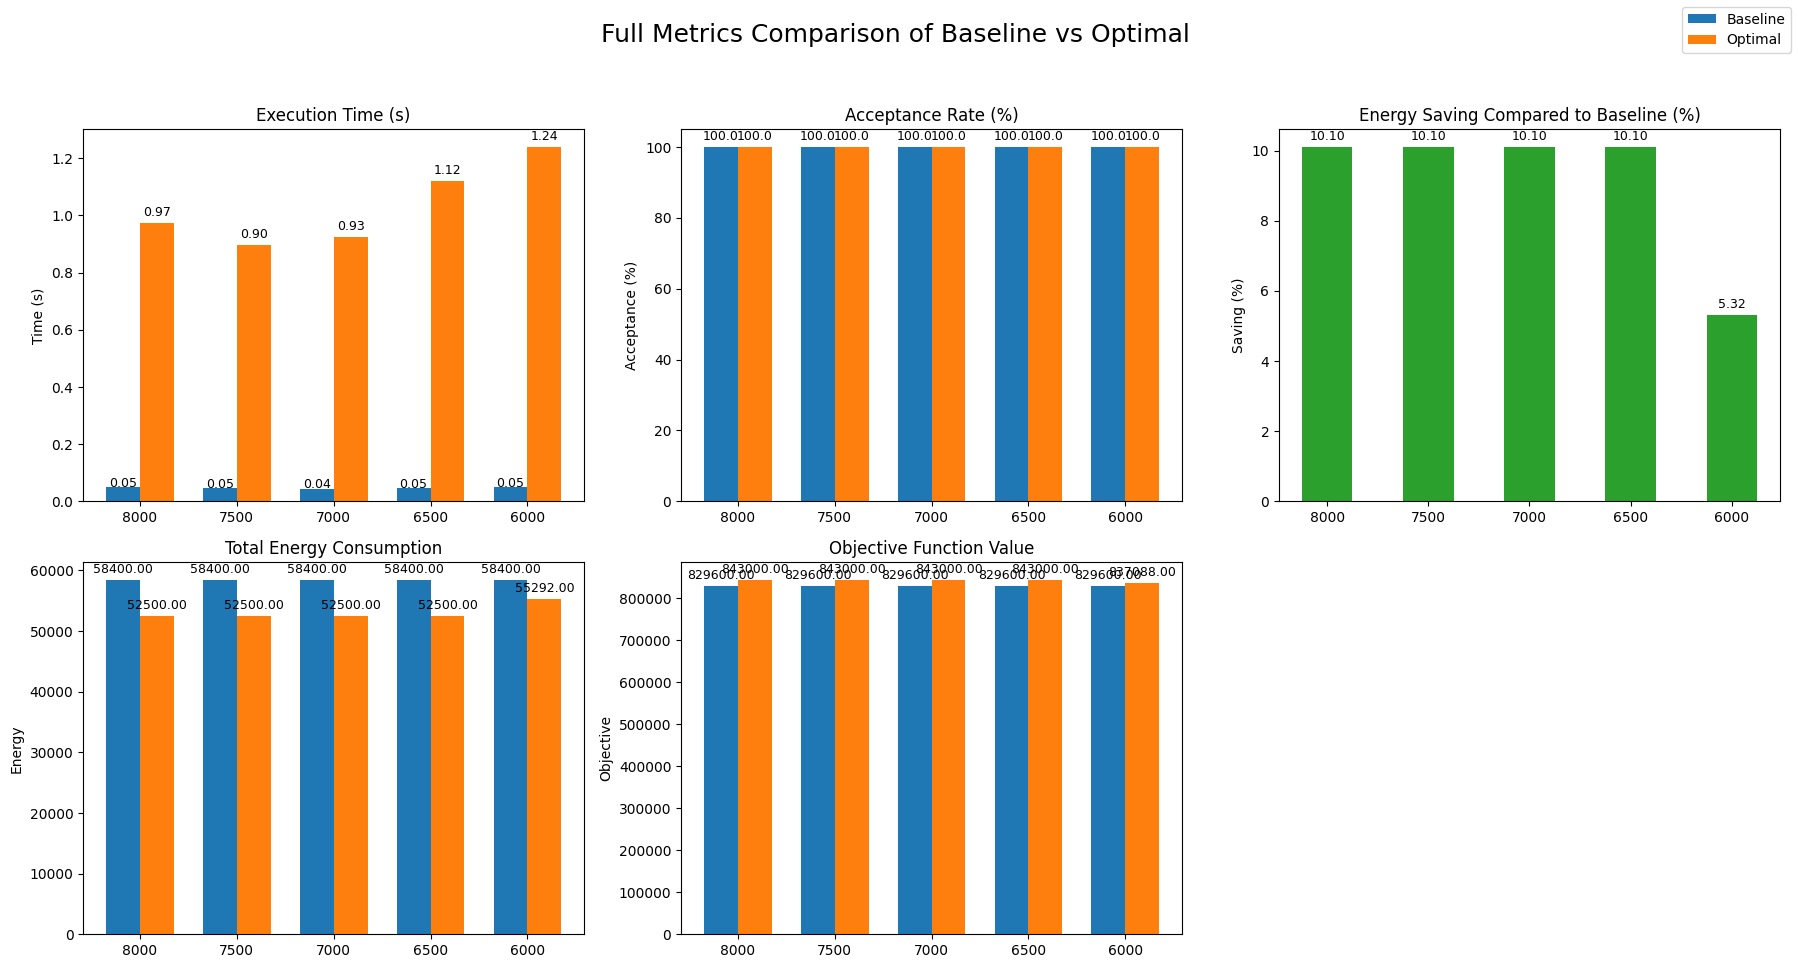

In [22]:
results_1 = run_and_plot_all(
    alpha_1=45000.0,
    alpha_2=2.0,
    alpha_3=1.0,
    E_PU_max_list=[8000, 7500, 7000, 6500, 6000]
)

Running multi E_PU_max experiment...
Testing E_PU_max = 5800
Testing E_PU_max = 5700
Testing E_PU_max = 5300
Testing E_PU_max = 5000
Testing E_PU_max = 4900
Plotting full summary chart...


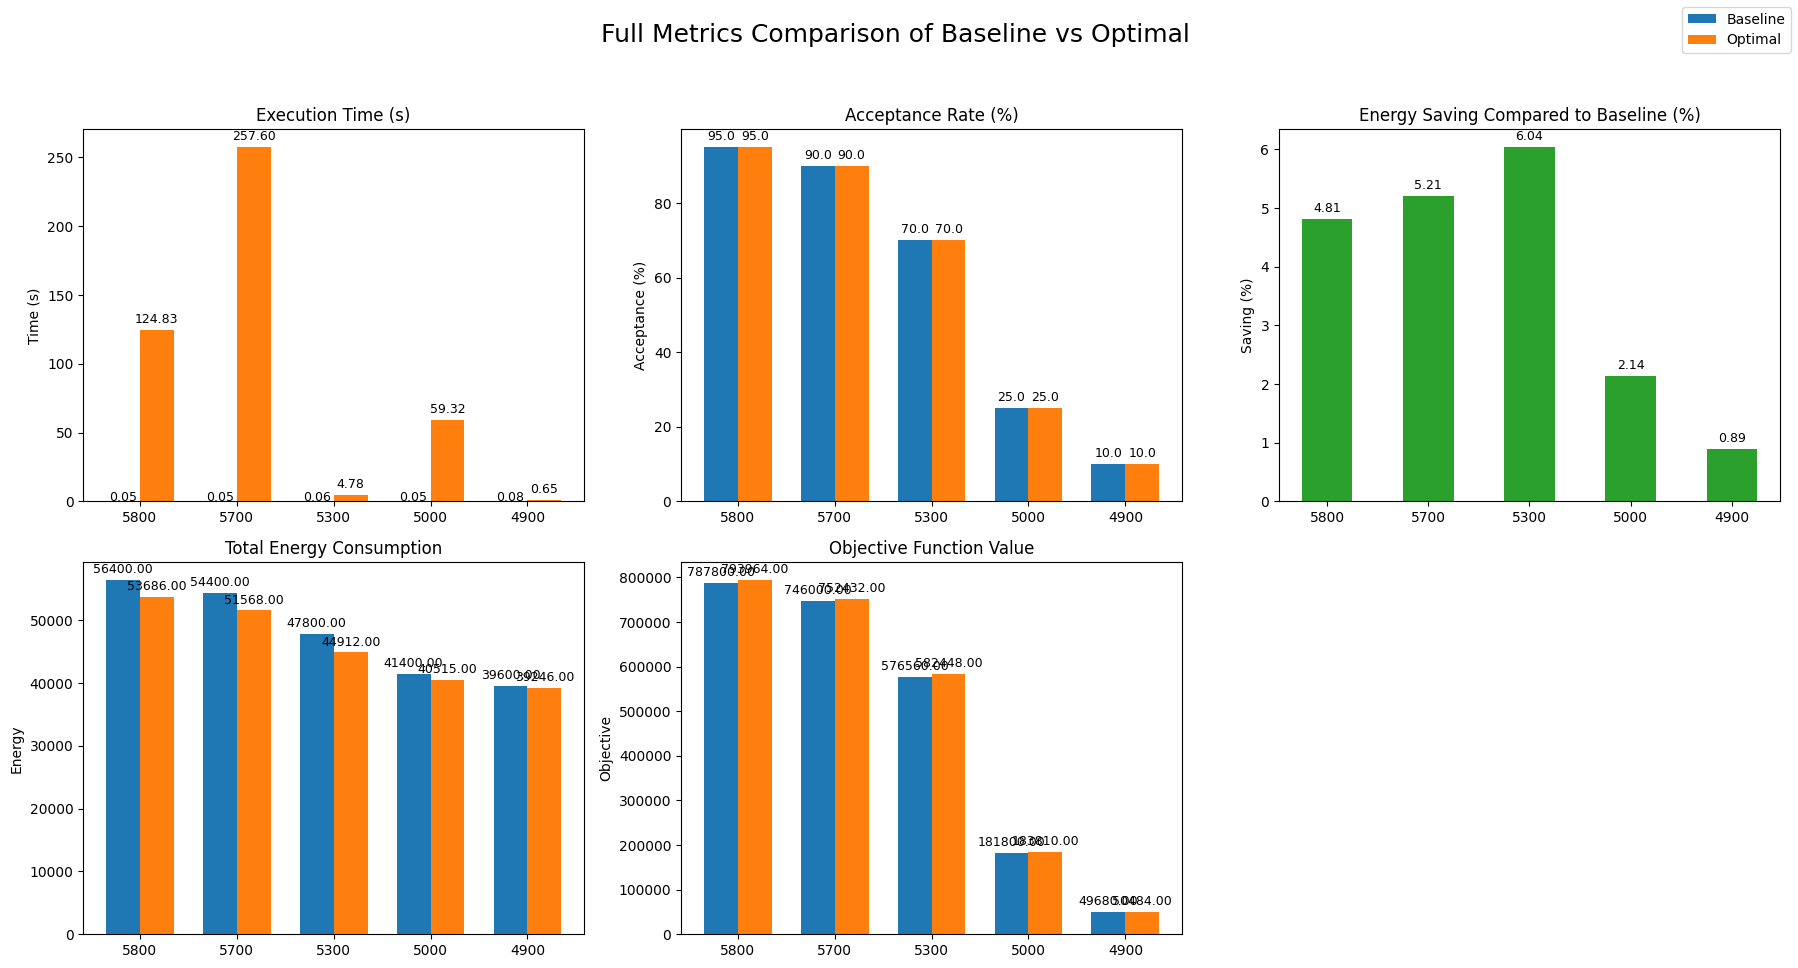

In [23]:
results_2 = run_and_plot_all(
    alpha_1=45000.0,
    alpha_2=2.0,
    alpha_3=1.0,
    E_PU_max_list=[5800,5700,5300,5000,4900]
)

### Baseline vs Optimal (Single Case)

In this experiment, we compare the performance of baseline and optimal scheduling strategies under the following settings:

- alpha_1 = 45000: Prioritizes maximizing task chain activation  
- alpha_2 = 2: Penalizes total task energy  
- alpha_3 = 1: Penalizes total PU energy

We visualize and summarize:
- Execution time
- Chain acceptance rate
- Energy consumption
- Objective value
- Task distribution by PU and energy level


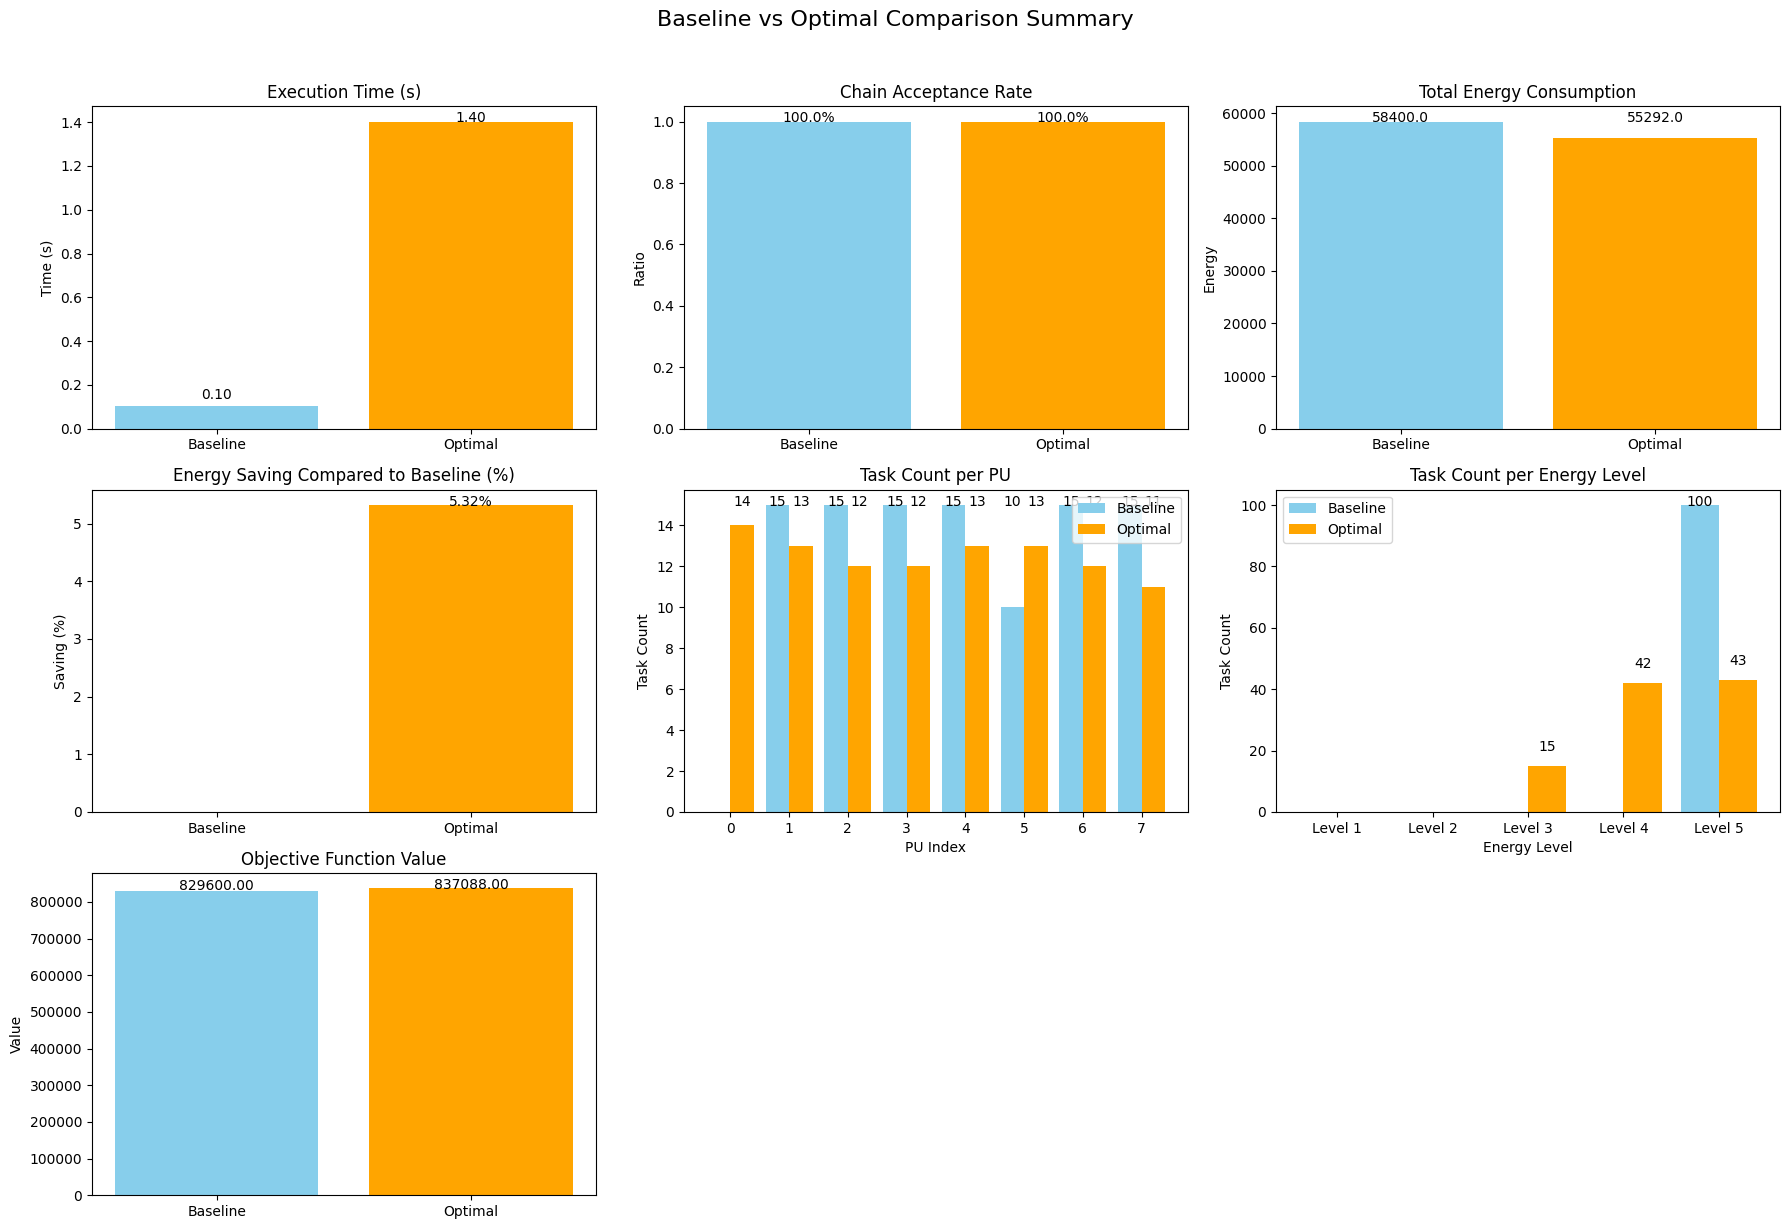

In [41]:
E_PU_max_test = [6000] * m
baseline_result = run_gurobi_model(alpha_1=45000, alpha_2=2, alpha_3=1, baseline=True,E_PU_max=E_PU_max_test)
optimal_result  = run_gurobi_model(alpha_1=45000, alpha_2=2, alpha_3=1, baseline=False,E_PU_max=E_PU_max_test)
visualize_baseline_vs_optimal_extended(baseline_result, optimal_result)

### Greedy Heuristic

This function implements a **greedy scheduling strategy** that processes task chains one-by-one:

- It selects the highest energy level (lowest latency) available.
- If the entire chain can be scheduled on a single PU under resource and energy constraints, it's accepted.
- Otherwise, the chain is rejected.

The algorithm favors **fast decisions** and **lightweight computation**, useful when full optimization (e.g., with Gurobi) is too slow or unnecessary.

Returned results include:
- Objective value
- Energy usage
- Chain acceptance rate
- PU-task assignments
- Task energy levels


In [20]:
def run_greedy_model(alpha_1=2500, alpha_2=10, alpha_3=1, E_PU_max=None):
    """
    Greedy scheduling heuristic for MAF task allocation.
    Tries to activate each task chain sequentially if resource and latency constraints are met.
    """

    import time
    start_time = time.time()

    if E_PU_max is None:
        E_PU_max = [8000] * m

    # Initialize variables
    delta = [0] * n              # Task activation
    y = [-1] * n                 # Task energy level
    w = [-1] * n                 # Task-to-PU assignment
    z = [0] * num_chains         # Chain activation
    pu_remaining_cpu = CPU_capacity[:]
    pu_workload = [0] * m
    task_energy_levels = [-1] * n
    pu_task_map = {j: [] for j in range(m)}
    accepted_chains = 0

    print("\n===== [Greedy chain Information] =====")
    for k in range(num_chains):
        task_list = chain_tasks[k]
        task_energy_per_chain = []
        task_cpu_usage = []
        chain_latency = 0
        chain_cpu = 0

        # Step 1: Try to assign tasks to lowest possible energy level (here reversed → highest level)
        for i in task_list:
            for l in reversed(range(K)):
                level = l
                break  # Always take the highest feasible (greedy)
            latency = L_levels[level]
            cpu = f_v_levels[level]
            task_energy_per_chain.append(level)
            task_cpu_usage.append(cpu)
            chain_latency += latency
            chain_cpu += cpu

        total_chain_latency = chain_latency + (len(task_list) - 1)
        if total_chain_latency > L_max[k]:
            print(f"❌ Chain {k} skipped: latency too high ({total_chain_latency} > {L_max[k]})")
            continue

        assigned_to_pu = False
        for j in range(m):
            if pu_remaining_cpu[j] >= chain_cpu:
                new_workload = pu_workload[j] + sum(L_levels[task_energy_per_chain[idx]] for idx in range(len(task_list)))
                new_pu_energy = P_idle[j] * (T_total - new_workload) + (P_max[j] - P_idle[j]) * new_workload
                if new_pu_energy > E_PU_max[j]:
                    continue

                # Assign all tasks in chain to PU j
                for idx, i in enumerate(task_list):
                    delta[i] = 1
                    y[i] = task_energy_per_chain[idx]
                    w[i] = j
                    task_energy_levels[i] = task_energy_per_chain[idx]
                    pu_task_map[j].append(i)
                    pu_remaining_cpu[j] -= task_cpu_usage[idx]
                    pu_workload[j] += L_levels[task_energy_per_chain[idx]]
                z[k] = 1
                accepted_chains += 1
                assigned_to_pu = True
                print(f"✅ Chain {k} activated (PU {j}, latency = {total_chain_latency}, CPU = {chain_cpu})")
                break

        if not assigned_to_pu:
            print(f"❌ Chain {k} skipped: resources or energy limit exceeded (CPU = {chain_cpu})")

    # Final statistics
    maf_energy = sum(E_levels[y[i]] for i in range(n) if y[i] != -1)
    pu_energy = [
        P_idle[j] * (T_total - pu_workload[j]) + (P_max[j] - P_idle[j]) * pu_workload[j]
        for j in range(m)
    ]
    total_pu_energy = sum(pu_energy)
    total_energy = maf_energy + total_pu_energy
    acceptance_rate = accepted_chains / num_chains
    runtime = time.time() - start_time
    objective = alpha_1 * sum(z) - alpha_2 * maf_energy - alpha_3 * total_pu_energy

    print(f"Greedy Summary: Accepted {accepted_chains}/{num_chains} chains, acceptance = {acceptance_rate:.2%}")
    for j in range(m):
        print(f"PU {j}: Energy = {pu_energy[j]:.2f} / Limit = {E_PU_max[j]}")

    return {
        "Mode": "Greedy",
        "Objective Value": objective,
        "Accepted Chains": accepted_chains,
        "Total PU Energy": total_pu_energy,
        "Total Task Energy": maf_energy,
        "Runtime": runtime,
        "PU Task Assignment": pu_task_map,
        "Task Energy Levels": task_energy_levels,
        "Activated Chain List": z,
        "Total Chains": num_chains
    }

def gurobi_results(result):
    # Summary Section
    df_summary = pd.DataFrame({
        "Metric": [
            "Model", "E_PU_max", "Alphas (α1, α2, α3)",
            "Objective Value", "Acceptance Rate (%)",
            "Total PU Energy", "Total Task Energy", "Runtime (s)",
            "Accepted Chains", "Total Chains"
        ],
        "Value": [
            result["model"],
            str(result["E_PU_max"]),
            str(result["alphas"]),
            round(result["objective"], 2),
            f"{result['acceptance_rate'] * 100:.2f}%",
            round(result["total_pu_energy"], 2),
            round(result["total_task_energy"], 2),
            round(result["Runtime"], 2),
            result["Accepted Chains"],
            result["Total Chains"]
        ]
    })

    # PU Task Assignment Section
    df_pu = pd.DataFrame([
        {"Metric": f"PU {pu}", "Value": str(tasks)}
        for pu, tasks in result["PU Task Assignment"].items()
    ])
    df_pu.loc[-1] = ["▶ PU Task Assignment", ""]
    df_pu.index = df_pu.index + 1
    df_pu.sort_index(inplace=True)

    # Task Energy Levels Section
    df_task = pd.DataFrame([
        {"Metric": f"Task {i}", "Value": f"Level {level}"}
        for i, level in enumerate(result["Task Energy Levels"])
    ])
    df_task.loc[-1] = ["▶ Task Energy Levels", ""]
    df_task.index = df_task.index + 1
    df_task.sort_index(inplace=True)

    # Activated Chain List Section
    df_chain = pd.DataFrame([
        {"Metric": f"Chain {k}", "Value": "Yes ✅" if act else "No ❌"}
        for k, act in enumerate(result["Activated Chain List"])
    ])
    df_chain.loc[-1] = ["▶ Activated Chain List", ""]
    df_chain.index = df_chain.index + 1
    df_chain.sort_index(inplace=True)

    # Combine all
    df_all = pd.concat([
        df_summary,
        pd.DataFrame([["─" * 40, "─" * 40]], columns=["Metric", "Value"]),
        df_pu,
        pd.DataFrame([["─" * 40, "─" * 40]], columns=["Metric", "Value"]),
        df_task,
        pd.DataFrame([["─" * 40, "─" * 40]], columns=["Metric", "Value"]),
        df_chain
    ], ignore_index=True)

    # Styled HTML with wider scroll box
    styled_html = df_all.style.set_properties(**{
        'text-align': 'left',
        'font-size': '14px',
        'font-family': 'Arial'
    }).set_caption("Gurobi Optimization Full Report").to_html()

    scroll_box = f"""
    <div style="max-height:500px; overflow-y:auto; border:1px solid #ccc; padding:15px; margin-top:10px; width:1000px;">
        {styled_html}
    </div>
    """
    display(HTML(scroll_box))

### Multi-Model Evaluation with Varying PU Energy Budgets

We evaluate all three models—**Baseline**, **Optimal (Gurobi)**, and **Greedy**—across different values of \( E_{\text{PU,max}} \):

- alpha_1 = 25000: Task chain activation reward
- alpha_2 = 1.5: Task energy penalty
- alpha_3 = 1.0 : PU energy penalty

This analysis helps us understand how energy constraints affect model performance in terms of:
- Objective value
- Total energy usage
- Chain acceptance rate
- Runtime

The `plot_model()` function generates a summary comparison.


In [51]:
# Greedy / Gurobi Optimal / Gurobi Baseline 
def run_all_models(E_PU_max_list, alpha_combinations):
    results = []

    for E_PU_max in E_PU_max_list:
        for alpha_1, alpha_2, alpha_3 in alpha_combinations:
            print(f"Test Data: alpha=({alpha_1}, {alpha_2}, {alpha_3}), E_PU_max={E_PU_max}")

            # Run Gurobi Baseline
            print("Gurobi [Baseline]")
            result_baseline = run_gurobi_model(
                alpha_1=alpha_1,
                alpha_2=alpha_2,
                alpha_3=alpha_3,
                baseline=True,
                E_PU_max=E_PU_max
            )
            if result_baseline:
                result_baseline["model"] = "Gurobi-Baseline"
                result_baseline["E_PU_max"] = E_PU_max.copy()
                result_baseline["alphas"] = (alpha_1, alpha_2, alpha_3)
                results.append(result_baseline)

            # Run Gurobi Optimal
            print("Gurobi [Optimal]")
            result_optimal = run_gurobi_model(
                alpha_1=alpha_1,
                alpha_2=alpha_2,
                alpha_3=alpha_3,
                baseline=False,
                E_PU_max=E_PU_max
            )
            if result_optimal:
                result_optimal["model"] = "Gurobi-Optimal"
                result_optimal["E_PU_max"] = E_PU_max.copy()
                result_optimal["alphas"] = (alpha_1, alpha_2, alpha_3)
                results.append(result_optimal)

            # Run Greedy
            print("Greedy")
            result_greedy = run_greedy_model(
                alpha_1=alpha_1,
                alpha_2=alpha_2,
                alpha_3=alpha_3,
                E_PU_max=E_PU_max
            )
            result_greedy["model"] = "Greedy"
            result_greedy["E_PU_max"] = E_PU_max.copy()
            result_greedy["alphas"] = (alpha_1, alpha_2, alpha_3)
            results.append(result_greedy)

    return results


def plot_model(all_results, save_folder=None):
    import os
    import matplotlib.pyplot as plt

    def normalize_keys(result):
        """
        Ensure all models have consistent field names for comparison.
        Converts keys to lowercase format expected by this plot.
        """
        if "Runtime" in result:
            result["runtime"] = result["Runtime"]
        if "Total PU Energy" in result:
            result["total_pu_energy"] = result["Total PU Energy"]
        if "Total Task Energy" in result:
            result["total_task_energy"] = result["Total Task Energy"]
        if "Accepted Chains" in result and "Total Chains" in result:
            result["acceptance_rate"] = result["Accepted Chains"] / result["Total Chains"]

    if save_folder:
        os.makedirs(save_folder, exist_ok=True)

    for i in range(0, len(all_results), 3):
        models = {r["model"]: r for r in all_results[i:i+3]}

        if "Gurobi-Baseline" in models and "Gurobi-Optimal" in models and "Greedy" in models:
            result_baseline = models["Gurobi-Baseline"]
            result_optimal = models["Gurobi-Optimal"]
            result_greedy = models["Greedy"]

            # Normalize all keys
            normalize_keys(result_baseline)
            normalize_keys(result_optimal)
            normalize_keys(result_greedy)

            e_max_val = result_greedy["E_PU_max"][0]
            alpha_val = result_greedy.get("alphas", ("?", "?", "?"))
            alpha_str = f"α=({alpha_val[0]}, {alpha_val[1]}, {alpha_val[2]})"

            fig, axs = plt.subplots(2, 2, figsize=(16, 10))
            labels = ["Gurobi Baseline", "Gurobi Optimal", "Greedy"]

            times = [result_baseline["runtime"], result_optimal["runtime"], result_greedy["runtime"]]
            acceptance = [result_baseline["acceptance_rate"], result_optimal["acceptance_rate"], result_greedy["acceptance_rate"]]
            energy_baseline = result_baseline["total_pu_energy"] + result_baseline["total_task_energy"]
            energy_optimal = result_optimal["total_pu_energy"] + result_optimal["total_task_energy"]
            energy_greedy = result_greedy["total_pu_energy"] + result_greedy["total_task_energy"]
            total_energy = [energy_baseline, energy_optimal, energy_greedy]

            saving_values = [
                0,
                (energy_baseline - energy_optimal) / energy_baseline * 100,
                (energy_baseline - energy_greedy) / energy_baseline * 100
            ]

            new_colors = ["#6A5ACD", "#20B2AA", "#FFA07A"]  # Academic-style color palette

            # 1. Execution Time
            axs[0, 0].bar(labels, times, color=new_colors)
            axs[0, 0].set_title("Execution Time (s)")
            for idx, val in enumerate(times):
                axs[0, 0].text(idx, val, f"{val:.2f}", ha='center', va='bottom')

            # 2. Chain Acceptance Rate
            axs[0, 1].bar(labels, acceptance, color=new_colors)
            axs[0, 1].set_title("Chain Acceptance Rate")
            axs[0, 1].set_ylim(0, 1)
            for idx, val in enumerate(acceptance):
                axs[0, 1].text(idx, val, f"{val:.1%}", ha='center', va='bottom')

            # 3. Total Energy Consumption
            axs[1, 0].bar(labels, total_energy, color=new_colors)
            axs[1, 0].set_title("Total Energy Consumption")
            for idx, val in enumerate(total_energy):
                axs[1, 0].text(idx, val, f"{val:.1f}", ha='center', va='bottom')

            # 4. Energy Savings Compared to Baseline
            axs[1, 1].bar(labels, saving_values, color=new_colors)
            axs[1, 1].set_title("Energy Savings Compared to Baseline (%)")
            axs[1, 1].axhline(0, color='black', linewidth=0.8, linestyle='--')
            for idx, val in enumerate(saving_values):
                axs[1, 1].text(idx, val, f"{val:.2f}%", ha='center', va='bottom')

            fig.suptitle(f"E_PU_max = {e_max_val} | {alpha_str}", fontsize=16)
            fig.tight_layout(rect=[0, 0, 1, 0.96])
            plt.show()


Test Data: alpha=(45000, 2, 1), E_PU_max=[6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]
Gurobi [Baseline]
Gurobi [Optimal]
Greedy

===== [Greedy chain Information] =====
✅ Chain 0 activated (PU 0, latency = 109, CPU = 1000)
✅ Chain 1 activated (PU 1, latency = 109, CPU = 1000)
✅ Chain 2 activated (PU 2, latency = 109, CPU = 1000)
✅ Chain 3 activated (PU 3, latency = 109, CPU = 1000)
✅ Chain 4 activated (PU 4, latency = 109, CPU = 1000)
✅ Chain 5 activated (PU 5, latency = 87, CPU = 800)
✅ Chain 6 activated (PU 0, latency = 32, CPU = 300)
✅ Chain 7 activated (PU 1, latency = 32, CPU = 300)
✅ Chain 8 activated (PU 2, latency = 32, CPU = 300)
✅ Chain 9 activated (PU 3, latency = 32, CPU = 300)
✅ Chain 10 activated (PU 4, latency = 32, CPU = 300)
✅ Chain 11 activated (PU 5, latency = 32, CPU = 300)
✅ Chain 12 activated (PU 5, latency = 32, CPU = 300)
✅ Chain 13 activated (PU 6, latency = 32, CPU = 300)
✅ Chain 14 activated (PU 6, latency = 32, CPU = 300)
✅ Chain 15 activated (PU 6, laten

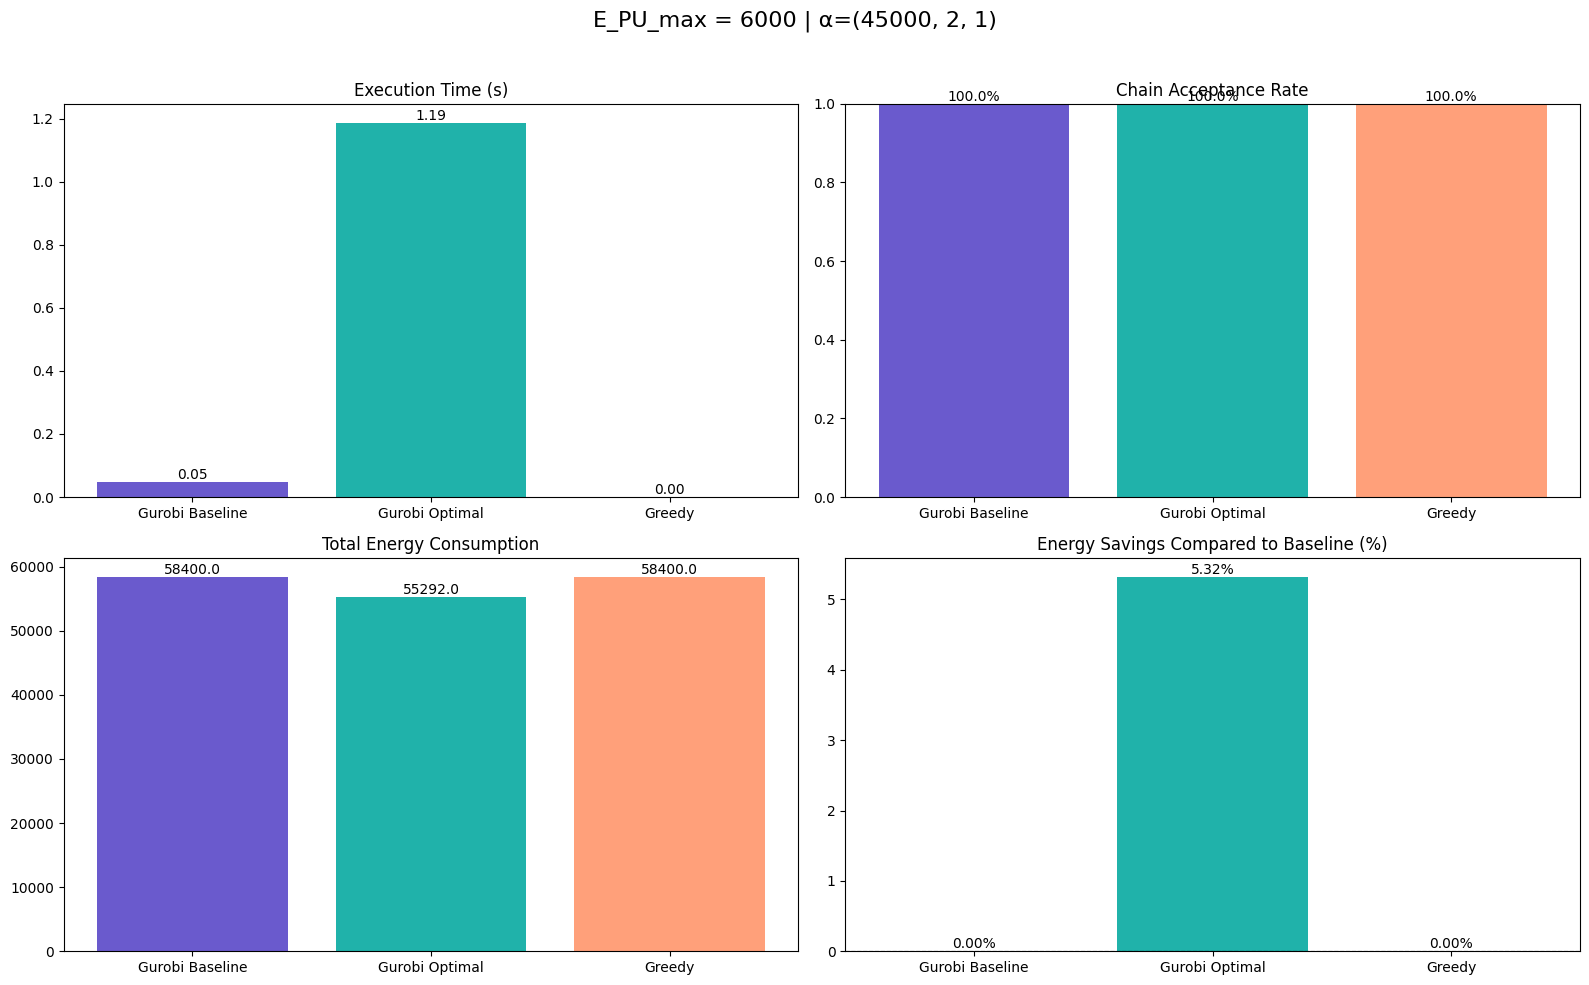

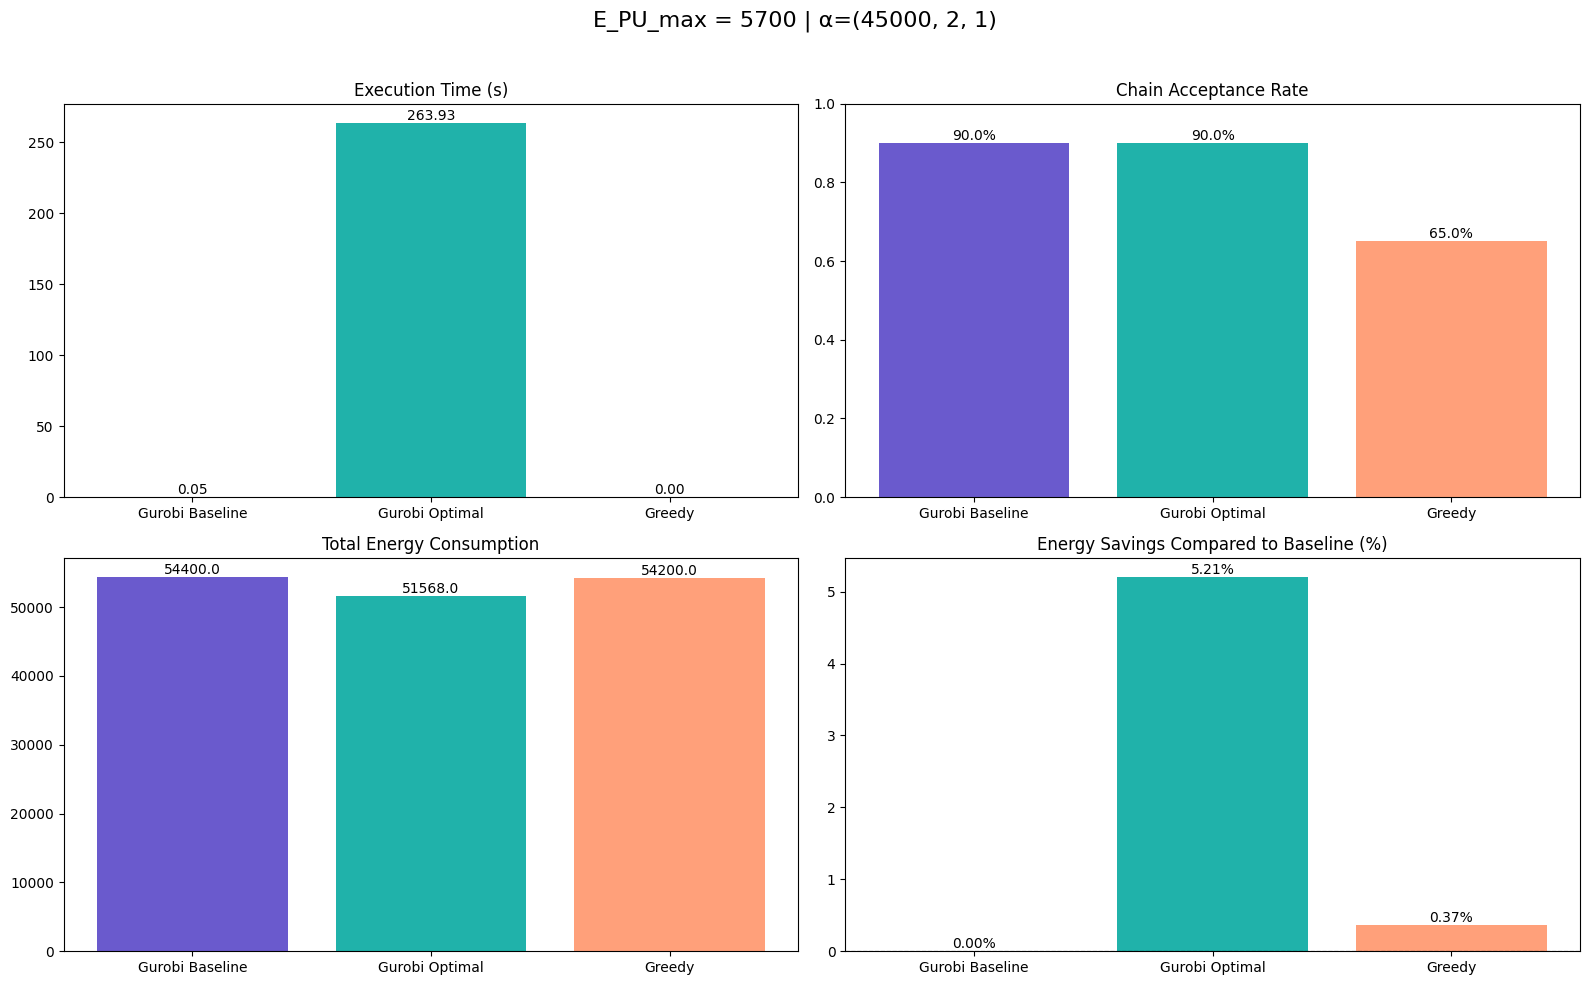

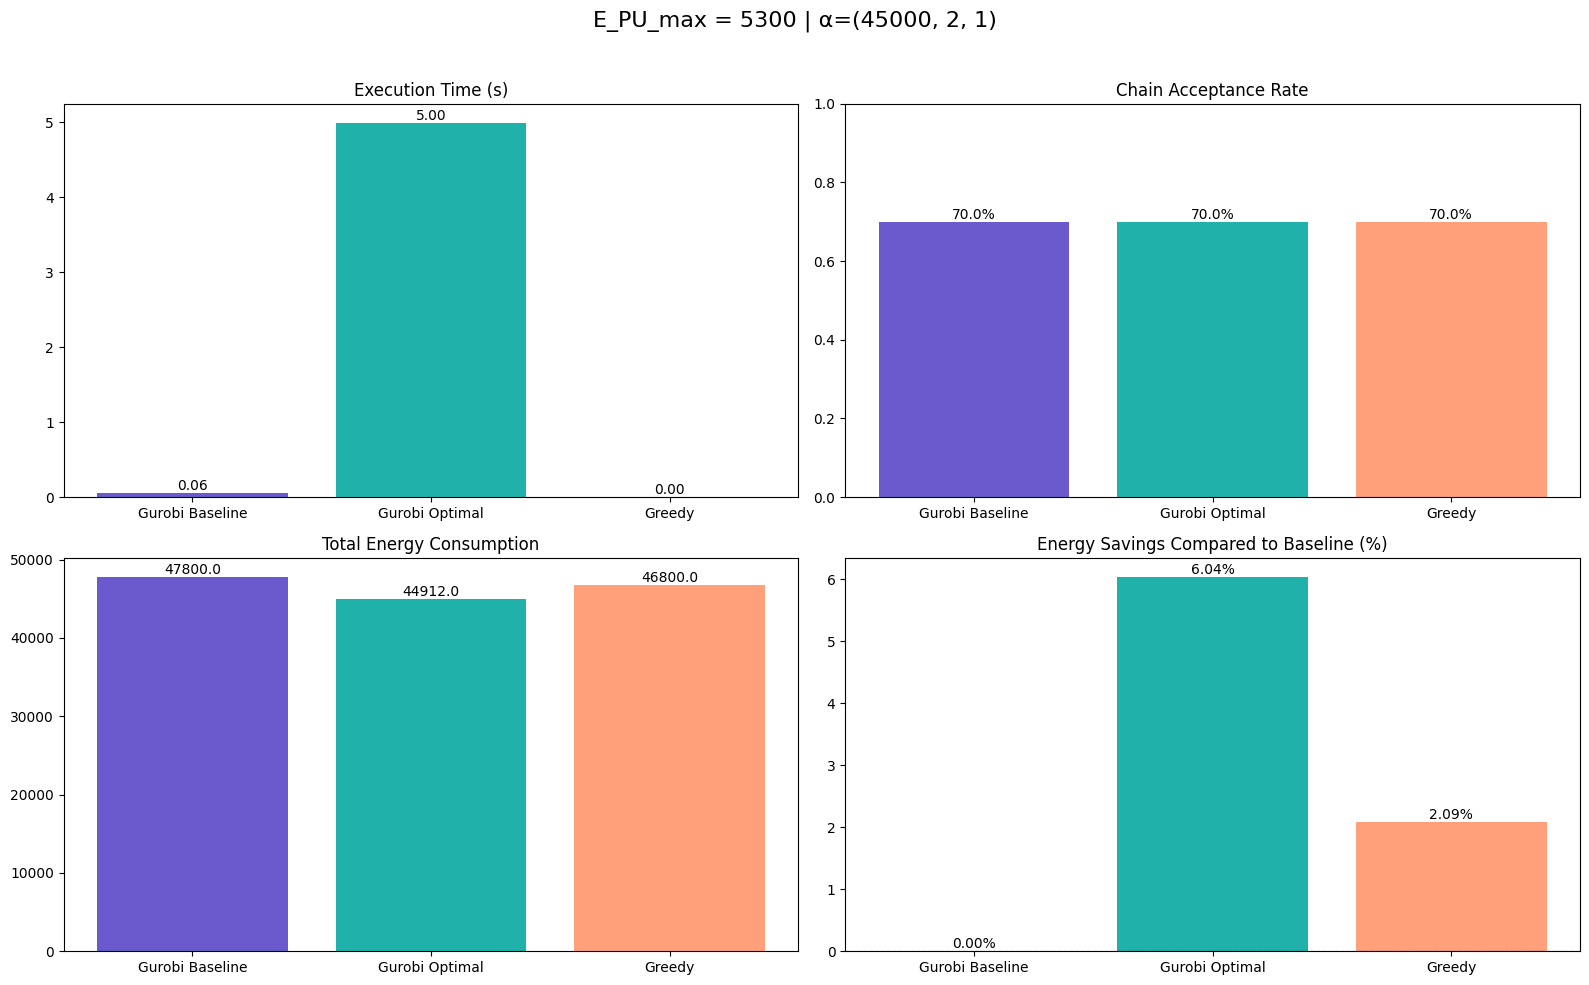

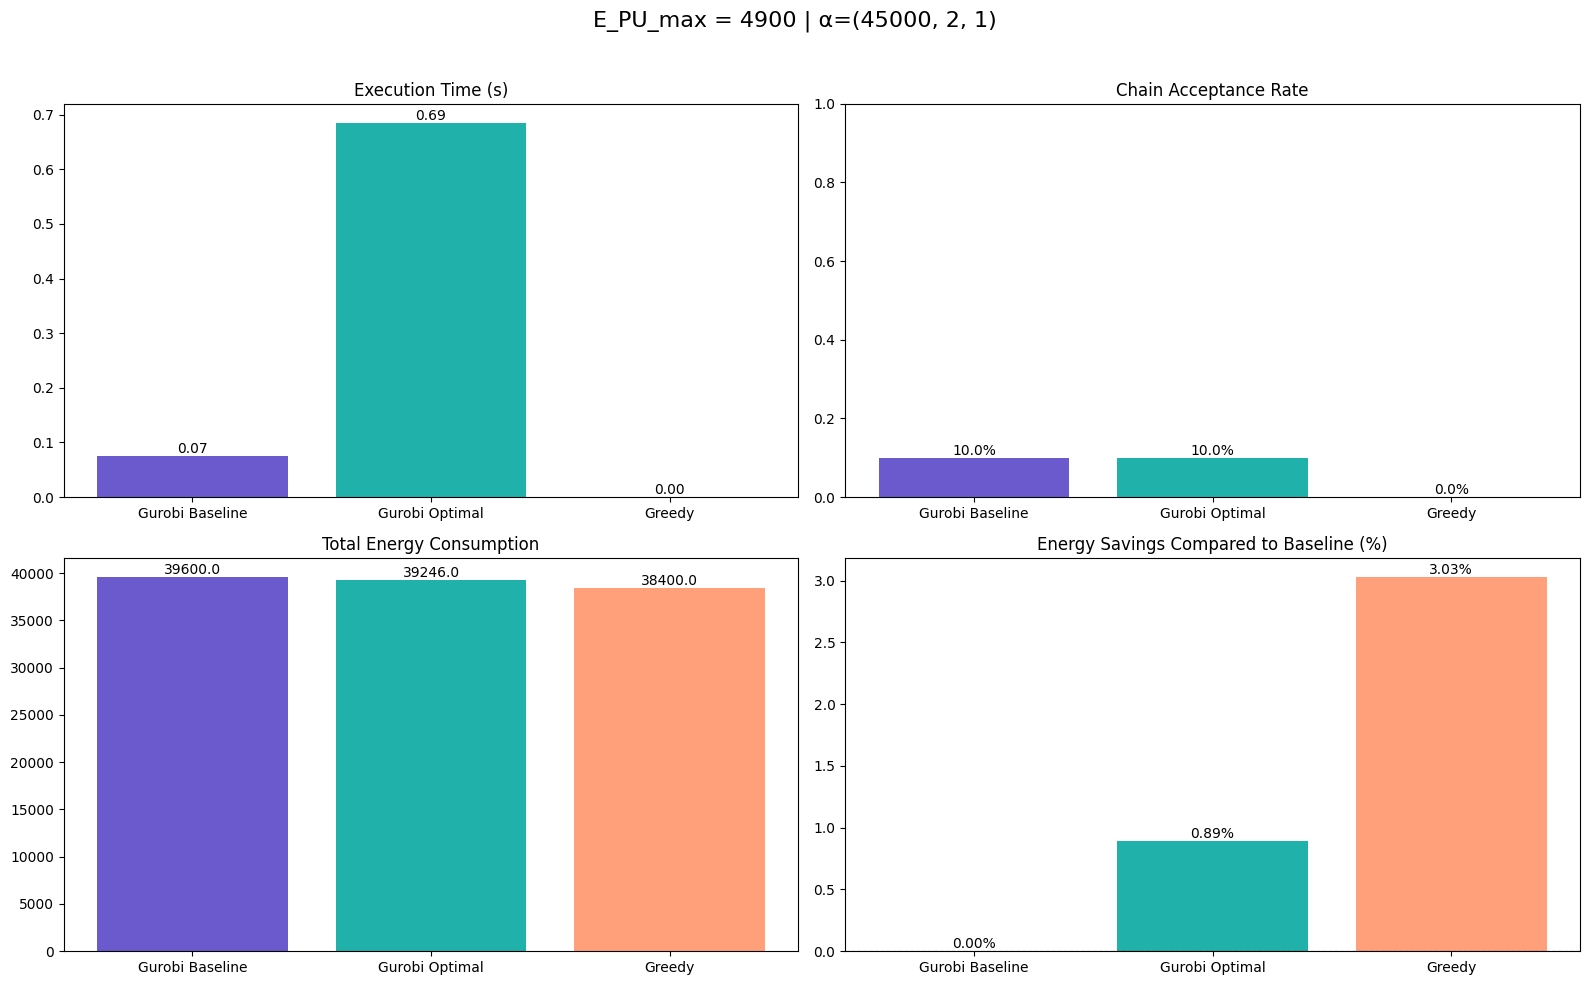

In [54]:
E_PU_max_list_test = [
    [6000] * m,
    [5700] * m,
    [5300] * m,
    [4900] * m
]

alpha_combination_1 = [
    (45000, 2, 1)
]

# Run all models under each E_PU_max setting
all_results_1 = run_all_models(E_PU_max_list_test, alpha_combination_1)


# Plot results
plot_model(all_results_1)


In [22]:
E_PU_max_test = [7000] * m
baseline_result = run_gurobi_model(alpha_1=45000, alpha_2=2, alpha_3=1, baseline=True, E_PU_max=E_PU_max_test)
optimal_result  = run_gurobi_model(alpha_1=45000, alpha_2=2, alpha_3=1, baseline=False, E_PU_max=E_PU_max_test)


gurobi_results(baseline_result)
gurobi_results(optimal_result)





,Metric,Value
0,Model,Gurobi-Baseline
1,E_PU_max,"[7000, 7000, 7000, 7000, 7000, 7000, 7000, 7000]"
2,"Alphas (α1, α2, α3)","(45000, 2, 1)"
3,Objective Value,829600.000000
4,Acceptance Rate (%),100.00%
5,Total PU Energy,46400.000000
6,Total Task Energy,12000.000000
7,Runtime (s),0.060000
8,Accepted Chains,20
9,Total Chains,20


,Metric,Value
0,Model,Gurobi-Optimal
1,E_PU_max,"[7000, 7000, 7000, 7000, 7000, 7000, 7000, 7000]"
2,"Alphas (α1, α2, α3)","(45000, 2, 1)"
3,Objective Value,843000.000000
4,Acceptance Rate (%),100.00%
5,Total PU Energy,48000.000000
6,Total Task Energy,4500.000000
7,Runtime (s),0.930000
8,Accepted Chains,20
9,Total Chains,20
